In [1]:
##Importing libraries
from joblib import dump, load
import os, sys, pickle, time, re, csv
from collections import defaultdict#

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [2]:
def matrix_triangle(a,direction='upper',return_indices=False):
    if direction=='upper':
        indices=np.triu_indices(len(a), k = 1)
    if direction=='lower':
        indices=np.tril_indices(len(a), k = -1)
    triangle=a[indices]
    if return_indices==True:
        return(triangle,indices)
    else:
        return(triangle)
    
def smooth_circular(x,sigma=10):
    return(gaussian_filter1d(np.hstack((x,x,x)),sigma,axis=0)[len(x):int(len(x)*2)])

def find_identical_indices(array_list):
    identical_groups = []
    checked = set()

    for i in range(len(array_list)):
        if i in checked:
            continue
        group = [i]
        for j in range(i + 1, len(array_list)):
            if np.array_equal(array_list[i], array_list[j]):
                group.append(j)
                checked.add(j)
        if len(group) > 1:
            identical_groups.append(group)

    return identical_groups

###Normalisation - i.e. how to get from array of raw firing rates and state times to
##normalised firing matrices

###Defining functions
def partition(alist, indices):
    return np.asarray([np.asarray(alist[i:j]) for i, j in zip(indices[:-1], indices[1:])])

def normalise(xx,num_bins=90,take_max=False):
    lenxx=len(xx)
    if lenxx<num_bins:
        xx=np.repeat(xx,10)/10
        lenxx=lenxx*10
    indices_polar=np.arange(lenxx)
    if take_max==True:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'max', bins=num_bins)[0]
    else:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'mean', bins=num_bins)[0]
    return(normalized_xx)

def raw_to_norm(raw_neuron,Trial_times_conc,num_states=4,return_mean=True,smoothing=True,\
                take_max=False,smoothing_sigma=10):
    raw_neuron_split=remove_empty(partition(list(raw_neuron),list(Trial_times_conc)))
    if len(raw_neuron_split)%num_states!=0:
        raw_neuron_split=raw_neuron_split[:len(raw_neuron_split)-len(raw_neuron_split)%num_states]
    
    if take_max==True:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii],take_max=True)\
                                          for ii in np.arange(len(raw_neuron_split))])
    else:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii]) for ii in np.arange(len(raw_neuron_split))])
    
    Actual_norm=(raw_neuron_split_norm.reshape(len(raw_neuron_split_norm)//num_states,\
                                               len(raw_neuron_split_norm[0])*num_states))
    
    if return_mean==True:
        Actual_norm_mean=np.nanmean(Actual_norm,axis=0)
        if smoothing==True:
            Actual_norm_smoothed=smooth_circular(Actual_norm_mean,sigma=smoothing_sigma)
            return(Actual_norm_smoothed)
        else:
            return(Actual_norm_mean)
    else:
        return(Actual_norm)

def polar_plot_stateX2(meanx,upperx,lowerx,ax,repeated,color='black',labels='states',plot_type='line',Marker=False,\
                      fields_booleanx=[], structure_abstract='ABCD',fontsize=20,set_max=False,max_val=1):
    rx = list(meanx)
    theta = list(range(len(rx)))
    thetax = [2 * np.pi * (x/len(rx)) for x in theta]
    r = rx + [rx[0]]
    theta = thetax + [thetax[0]]
    
    #ax=plt.subplot(111, projection='polar')
    
    if Marker==True:
        fields_booleanx=fields_booleanx*(np.max(upperx)+0.1*np.max(upperx))
        fields_boolean=list(fields_booleanx)+[list(fields_booleanx)[0]]

    upper=list(upperx)+[list(upperx)[0]]
    lower=list(lowerx)+[list(lowerx)[0]]
    
    if plot_type=='line':
        ax.plot(theta, r,color=color)
        ax.fill_between(theta, upper, lower, alpha=0.2,color=color)
        if set_max==False:
            ax.set_rmax(np.max(upper)+0.01*np.max(upper))
        else:
            ax.set_rmax(max_val)
            
        if Marker==True:
            ax.plot(theta, fields_boolean,color='black',linestyle='None',marker='.')

    elif plot_type=='bar':
        ax.bar(theta,r,width=5/len(r),color=color)
    elif plot_type=='marker':
        ax.plot(theta, r,color=color)
        
    
    ax.grid(True)
    #ax.set_rorigin(-1)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    if labels=='states':
        if structure_abstract=='ABCD':
            ax.set_xticklabels(['A', '', 'B', '', 'C', '', 'D', ''],fontsize=fontsize)
        elif structure_abstract=='AB' and repeated==False:
            ax.set_xticklabels(['A', '', '', '', 'B', '', '', ''],fontsize=fontsize)
        elif structure_abstract=='AB' and repeated==True:
            ax.set_xticklabels(['A', '', 'B', '', 'A', '', 'B', ''],fontsize=fontsize)
    elif labels == 'angles':
        ax.set_xticklabels(['0', '', '90', '', '180', '', '270', ''],fontsize=fontsize)

def arrange_plot_statecells_persessionX2(mouse_recday,neuron,Data_folder,sessions_included=None\
                                       ,fignamex=False,sigma=10,\
                                       save=False,plot=False,figtype='.svg', Marker=False,\
                                       fields_booleanx=[],measure_type='mean', abstract_structures=[],\
                                      repeated=False,behaviour_oversampling_factor=3,behaviour_rate=1000,\
                                       tracking_oversampling_factor=50):

    awake_sessions=session_dic['awake'][mouse_recday]
    awake_sessions_behaviour=session_dic_behaviour['awake'][mouse_recday]
    
    colors=np.repeat('blue',len(awake_sessions_behaviour))
    plot_boolean=np.repeat(False,len(awake_sessions_behaviour))
    plot_boolean[sessions_included]=True
    
    
    
    num_trials_day=np.load(Intermediate_object_folder+'Num_trials_'+mouse_recday+'.npy')

    fig= plt.figure(figsize=plt.figaspect(1)*4.5)
    fig.tight_layout()
    for awake_session_ind, timestamp in enumerate(awake_sessions_behaviour):
        structure_abstract=abstract_structures[awake_session_ind]
        
        if num_trials_day[awake_session_ind]<2:
            print('Not enough trials session'+str(awake_session_ind))
            continue
        if timestamp not in awake_sessions:
            print('Ephys not used for session'+str(awake_session_ind))
            continue
            
            
        try:
            norm_activity_all=np.load(Data_folder+'Neuron_'+mouse_recday+'_'+str(awake_session_ind)+'.npy')
        except:
            print('No file found session'+str(awake_session_ind))
            continue
        
        norm_activity_neuron=norm_activity_all[neuron]
        
        xxx=np.asarray(norm_activity_neuron).T
        standardized_FR=np.hstack([np.nanmean(xxx[ii],axis=0) for ii in range(len(xxx))])*\
        behaviour_oversampling_factor*behaviour_rate/tracking_oversampling_factor
        standardized_FR_sem=np.hstack([st.sem(xxx[ii],axis=0,nan_policy='omit') for ii in range(len(xxx))])*\
        behaviour_oversampling_factor*behaviour_rate/tracking_oversampling_factor
        standardized_FR_smoothed=smooth_circular(standardized_FR,sigma=sigma)            
        standardized_FR_sem_smoothed=smooth_circular(standardized_FR_sem,sigma=sigma)                    

        
        standardized_FR_smoothed_upper=standardized_FR_smoothed+standardized_FR_sem_smoothed
        standardized_FR_smoothed_lower=standardized_FR_smoothed-standardized_FR_sem_smoothed
       
        
        color=colors[awake_session_ind]
        
        ax = fig.add_subplot(1, len(awake_sessions_behaviour), awake_session_ind+1, projection='polar')
        if len(fields_booleanx)>0:
            polar_plot_stateX2(standardized_FR_smoothed,standardized_FR_smoothed_upper,standardized_FR_smoothed_lower,\
                              ax,color=color, Marker=Marker,fields_booleanx=fields_booleanx[awake_session_ind],\
                             structure_abstract=structure_abstract,repeated=repeated)
        else:
            polar_plot_stateX2(standardized_FR_smoothed,standardized_FR_smoothed_upper,standardized_FR_smoothed_lower,\
                              ax,color=color, Marker=False,structure_abstract=structure_abstract,repeated=repeated)
    plt.margins(0,0)
    #plt.tight_layout()
    if save==True:
        plt.savefig(fignamex+str(awake_session_ind)+figtype)
    if plot==True & plot_boolean[awake_session_ind]==True:
        plt.show()
    else:
        plt.close() 

In [3]:
###Folders

#Input_folder = 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Data/Human/'
#Ephys_output_folder = 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Results/Ephys/'
#Behaviour_output_folder= 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Results/Behaviour/'


Input_folder = '/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives/group/best_cells'

#Ephys_output_folder = 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Results/Ephys/'
#Behaviour_output_folder= 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Results/Behaviour/'




In [4]:
'''
reward_configs: a dictionary that contains a numpy of the different reward configurations, 
locations: a list of arrays of length n grids for the neuron, for the location the subjects were on. 
timings: It also contains a list of arrays for the timings, which are of dimensions n= number of repeats in this grid x 5. 
Time one corresponds to when they start state 'A',
the other 4 respectively refer to when they are entering a 'new state' i.e. uncovering a reward.

'''

"\nreward_configs: a dictionary that contains a numpy of the different reward configurations, \nlocations: a list of arrays of length n grids for the neuron, for the location the subjects were on. \ntimings: It also contains a list of arrays for the timings, which are of dimensions n= number of repeats in this grid x 5. \nTime one corresponds to when they start state 'A',\nthe other 4 respectively refer to when they are entering a 'new state' i.e. uncovering a reward.\n\n"

In [5]:
##Defining Task grid
from scipy.spatial import distance_matrix
from itertools import product
x=(0,1,2)
Task_grid=np.asarray(list(product(x, x)))
Task_grid_plotting=np.column_stack((Task_grid[:,1],Task_grid[:,0]))
Task_grid_plotting2=[]
for yy in np.arange(3):
    y=int(yy*2)
    for xx in np.arange(3):
        x=int(xx*2)    
        Task_grid_plotting2.append([x,y])
Task_grid_plotting2=np.asarray(Task_grid_plotting2)    
Task_grid2=np.column_stack((Task_grid_plotting2[:,1],Task_grid_plotting2[:,0]))
num_locations=9

In [25]:
import pickle
path=Input_folder+'/RHC_33_25_best_for_location_reg_raw'

with open(path, 'rb') as f:
    cell_dict = pickle.load(f)

In [26]:
###space
###decent:'/LEC_0_sub-31_best_for_location_reg'
###decent:'/LHC_0_sub-04_best_for_location_reg'
###bad:'/LEC_0_sub-15_best_for_location_reg'



###State
##'/LHC_2_sub-12_best_for_state_reg'
##/LHC_5_sub-25_best_for_state_reg
###'LINS_4_sub-50_best_for_state_reg'
##REC_11_sub-15_best_for_location_reg - not a lot of trials


In [27]:
cell_dict.keys()

dict_keys(['RHC_33_25', 'reward_configs', 'locations', 'timings'])

In [28]:
###concatenating sessions of the same task

Tasks=cell_dict['reward_configs']
identical_task_indices=find_identical_indices(Tasks)
unique_tasks=Tasks[[identical_task_indices[ii][0] for ii in range(len(identical_task_indices))]]

Activity_all=cell_dict[list(cell_dict.keys())[0]]
Location_all=cell_dict['locations']


Activity_all_pertask=[]
Location_all_pertask=[]

for task_ind in np.arange(len(unique_tasks)):
    ses_indices=identical_task_indices[task_ind]
    
    Activity_task=np.hstack((np.asarray(Activity_all)[ses_indices]))
    Location_task=np.hstack((np.asarray(Location_all)[ses_indices]))
    
    Activity_all_pertask.append(Activity_task)
    Location_all_pertask.append(Location_task)
    


/var/folders/h2/_86s79551w1734r87y2wlkk40000gt/T/ipykernel_39908/3090607093.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Activity_task=np.hstack((np.asarray(Activity_all)[ses_indices]))
/var/folders/h2/_86s79551w1734r87y2wlkk40000gt/T/ipykernel_39908/3090607093.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Location_task=np.hstack((np.asarray(Location_all)[ses_indices]))


In [29]:
'''
To plot:
1-place maps
2-state maps - predicted vs actual

'''

'\nTo plot:\n1-place maps\n2-state maps - predicted vs actual\n\n'

In [30]:
Task_grid_plotting

array([[0, 0],
       [1, 0],
       [2, 0],
       [0, 1],
       [1, 1],
       [2, 1],
       [0, 2],
       [1, 2],
       [2, 2]])

In [31]:
###Spatial maps
FR_maps_neuron=np.zeros((len(Activity_all_pertask),3,3))
FR_maps_neuron[:]=np.nan

FR_arrays_neuron=np.zeros((len(Activity_all_pertask),9))
FR_maps_neuron[:]=np.nan

for task_ind in np.arange(len(Activity_all_pertask)):
    Activity_task=Activity_all_pertask[task_ind]
    #print(len(Activity_ses))

    location_task=Location_all_pertask[task_ind]-1
    #print(len(location_ses))


    FR_array=st.binned_statistic(location_task,Activity_task,bins=np.arange(10))[0]

    FR_map=np.zeros((3,3))
    FR_map[:]=np.nan

    for loc_ind in np.arange(num_locations):
        FR_map[Task_grid_plotting[loc_ind][0],Task_grid_plotting[loc_ind][1]]=FR_array[loc_ind]
    FR_maps_neuron[task_ind]=FR_map

In [32]:
FR_array

array([0.20145712, 0.20339252, 0.20785433, 0.20337863, 0.18891549,
       0.20707596, 0.19303675, 0.18177948, 0.18208036])

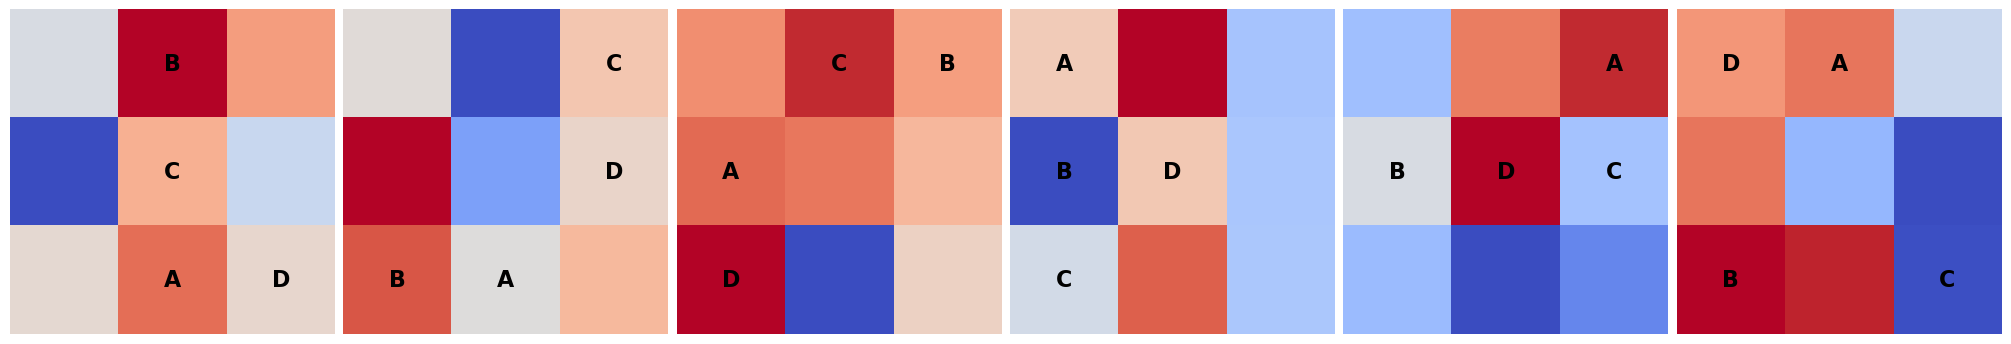

In [33]:
max_rate=np.nanmax(FR_maps_neuron)
min_rate=np.nanmin(FR_maps_neuron)

fig1, f1_axes = plt.subplots(figsize=(20, 20),ncols=len(FR_maps_neuron), nrows=1, constrained_layout=True)  
for task_ind in np.arange(len(FR_maps_neuron)):
    FR_map_neuron_task=FR_maps_neuron[task_ind]
    ax1=f1_axes[task_ind]
    ax1.matshow(FR_map_neuron_task, cmap='coolwarm')
    ax1.axis('off')
    for i_r, reward in enumerate(unique_tasks[task_ind]):
        if i_r == 0:
            write = 'A'
        elif i_r == 1:
            write = 'B'
        elif i_r == 2:
            write = 'C'
        elif i_r == 3:
            write = 'D'
        pos_idx = int(reward) - 1  # adjust to 0-index
        # Retrieve the row, col coordinates from Task_grid_plotting
        row, col = Task_grid_plotting[pos_idx]
        # Print the letter over the respective cell.
        ax1.text(col, row, write, ha='center', va='center',
                 color='black', fontsize=16, fontweight='bold')
            
            
            
plt.axis('off') 
plt.show()


In [34]:
unique_tasks

array([[6., 4., 5., 9.],
       [6., 3., 7., 8.],
       [2., 7., 4., 3.],
       [1., 2., 3., 5.],
       [7., 2., 8., 5.],
       [4., 3., 9., 1.]])

In [35]:
FR_maps_neuron

array([[[0.19257221, 0.20950563, 0.20099432],
        [0.17696867, 0.19943347, 0.19093988],
        [0.19414704, 0.20453773, 0.19458048]],

       [[0.1995296 , 0.18596828, 0.20228083],
        [0.21242236, 0.19137597, 0.20057307],
        [0.20956594, 0.19928327, 0.20352898]],

       [[0.18678304, 0.19676012, 0.18467304],
        [0.19090358, 0.18957968, 0.1808978 ],
        [0.19882367, 0.14513274, 0.17562254]],

       [[0.21271008, 0.22940156, 0.20136519],
        [0.18795394, 0.21312756, 0.20173805],
        [0.20716639, 0.22420965, 0.20194647]],

       [[0.17725632, 0.19780546, 0.20379024],
        [0.1842863 , 0.20536956, 0.17771798],
        [0.17672209, 0.16491754, 0.17055948]],

       [[0.20145712, 0.20337863, 0.19303675],
        [0.20339252, 0.18891549, 0.18177948],
        [0.20785433, 0.20707596, 0.18208036]]])

In [36]:
FR_arrays=np.vstack((FR_maps_neuron.T)).T
np.nanmean(matrix_triangle(np.corrcoef(FR_arrays)))

-0.023029491068023364

_____
Example output neuron
trials x normalised time bins
dashed lines represent reward times
0
7319


/var/folders/h2/_86s79551w1734r87y2wlkk40000gt/T/ipykernel_39908/688750525.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([np.asarray(alist[i:j]) for i, j in zip(indices[:-1], indices[1:])])


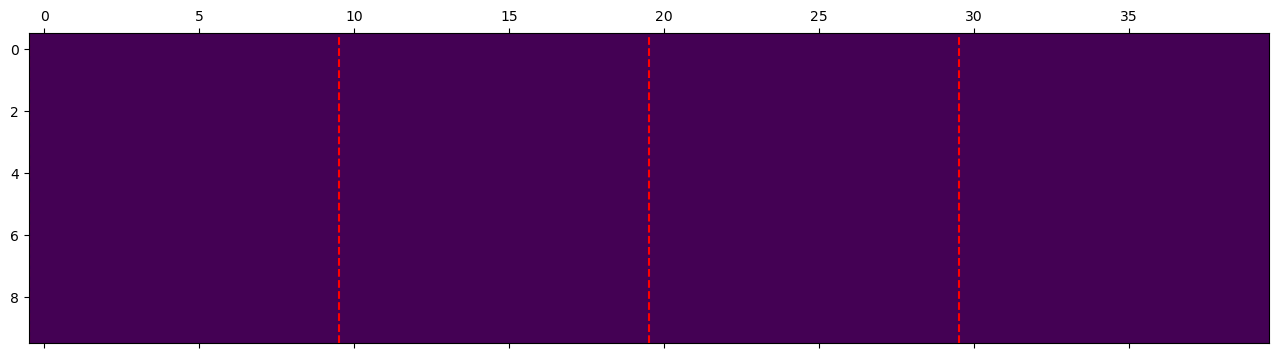

1
6834


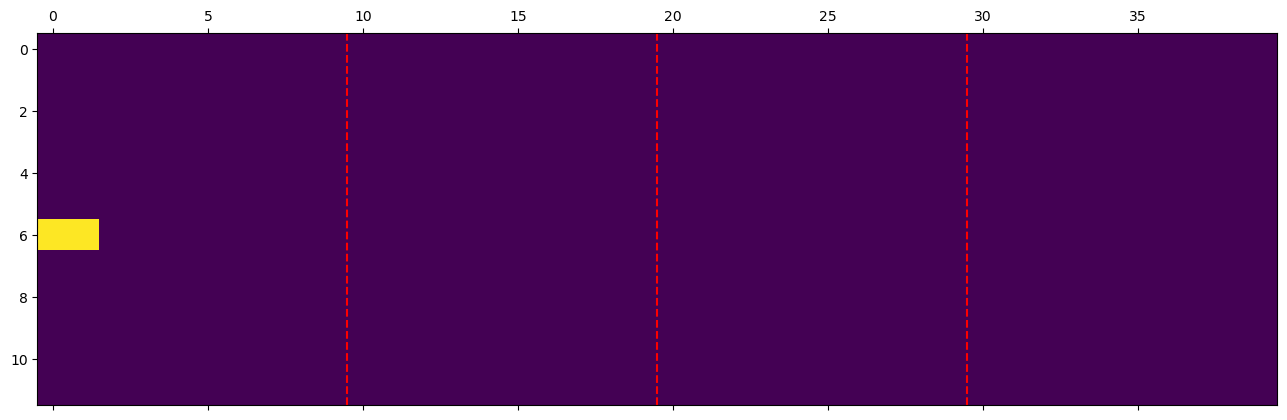

2
6262


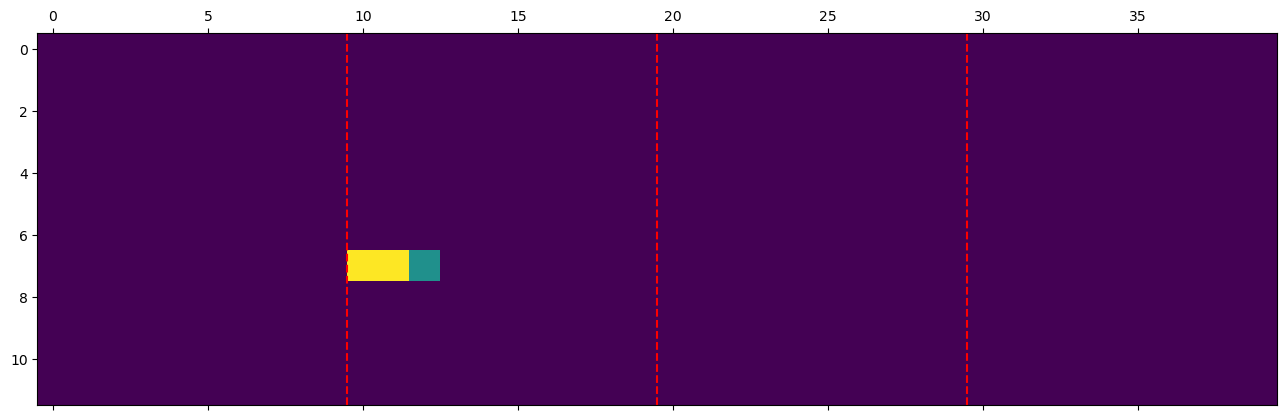

3
4899


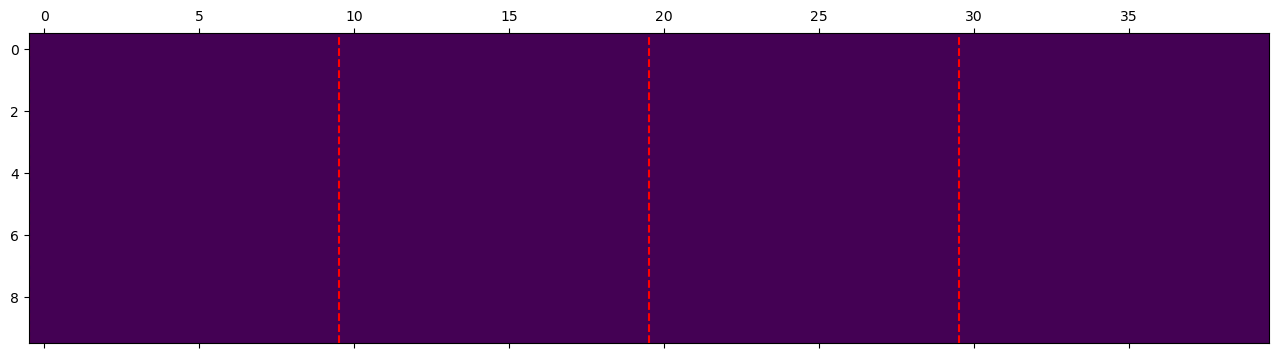

4
6903


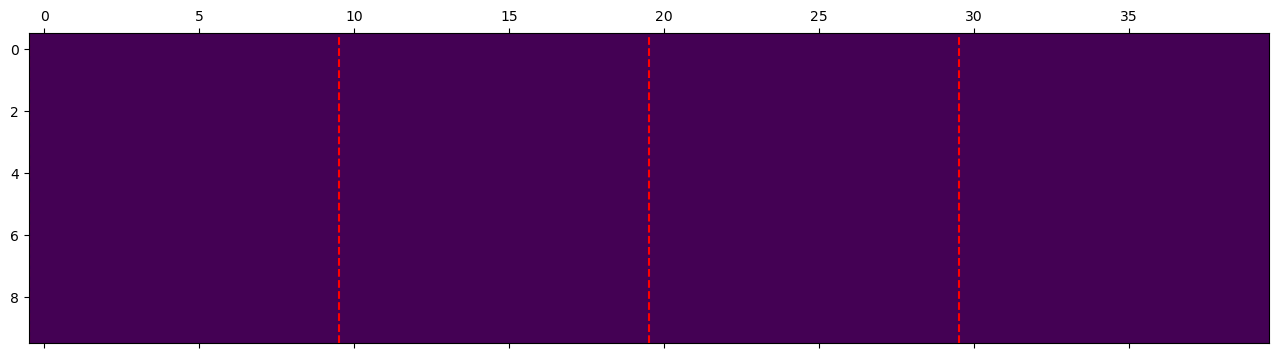

5
5669


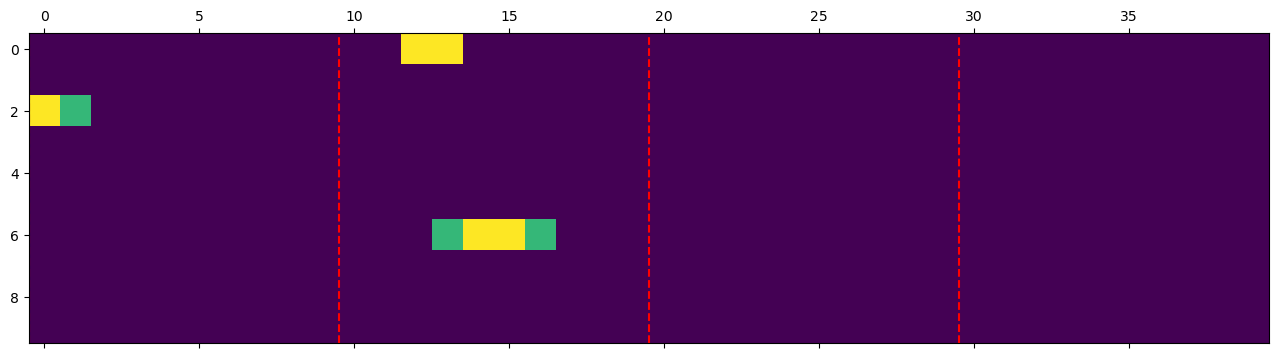

6
4469


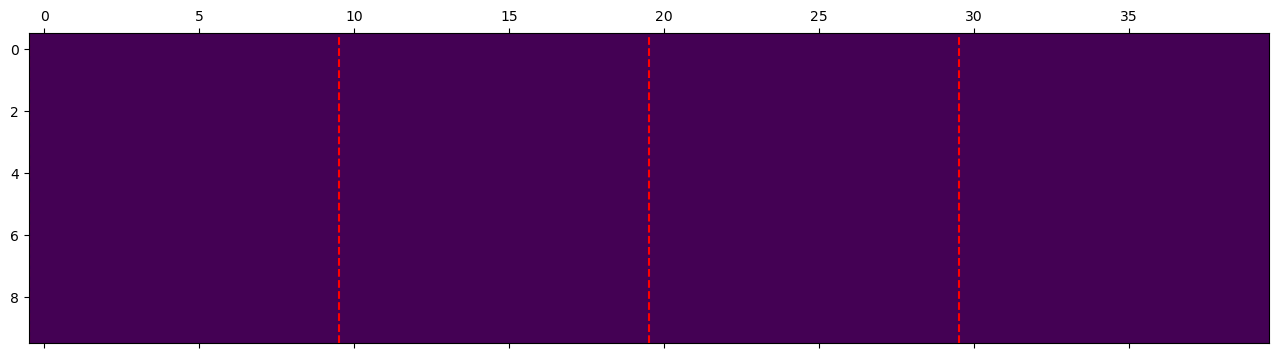

7
5179


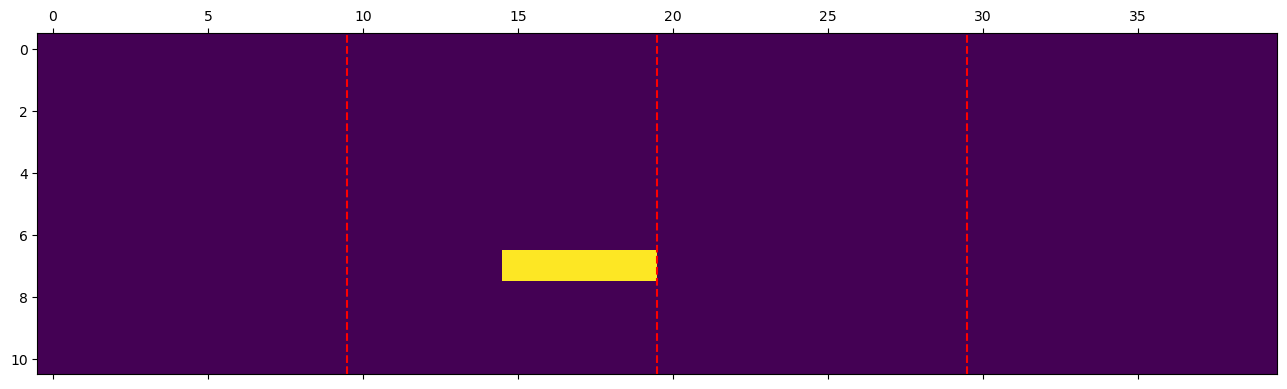

8
7037


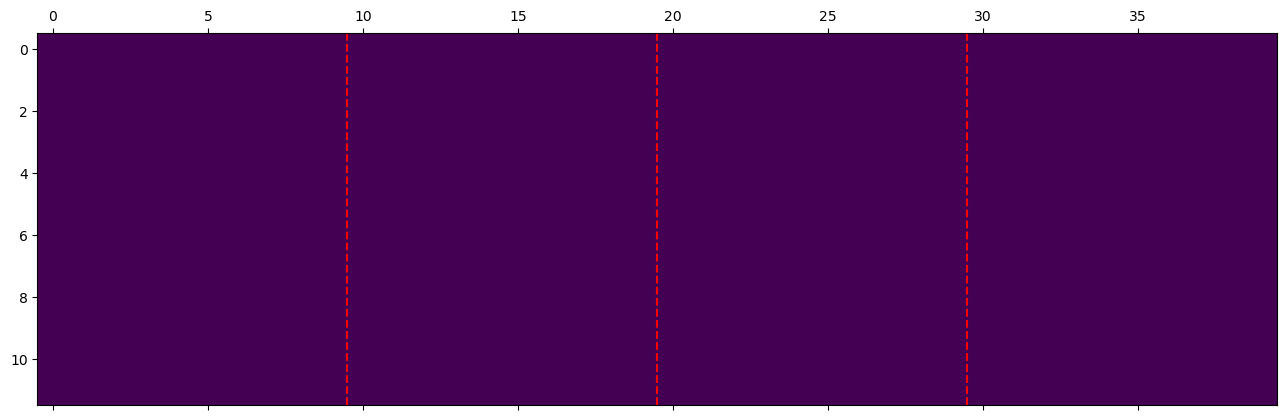

9
5269


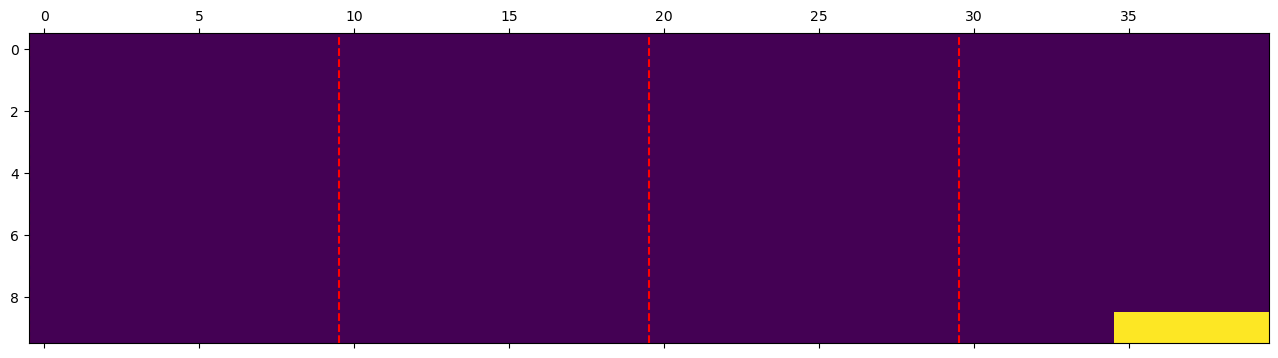

10
4669


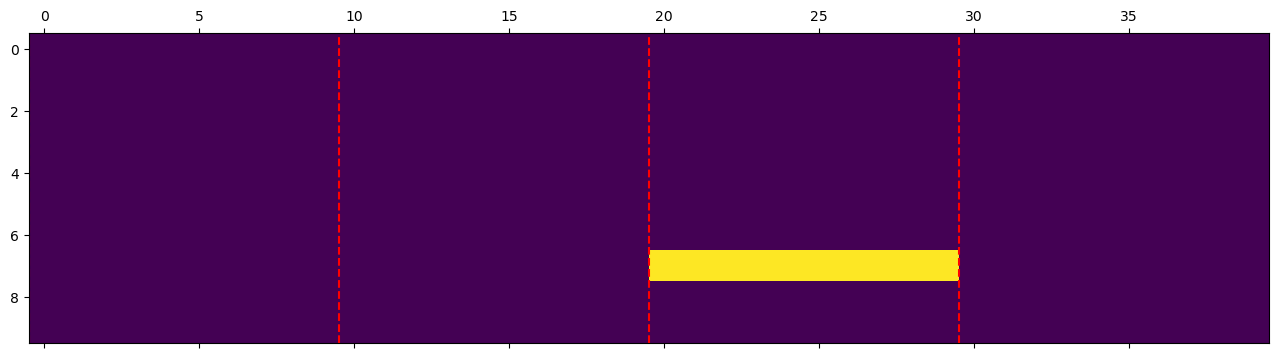

11
6887


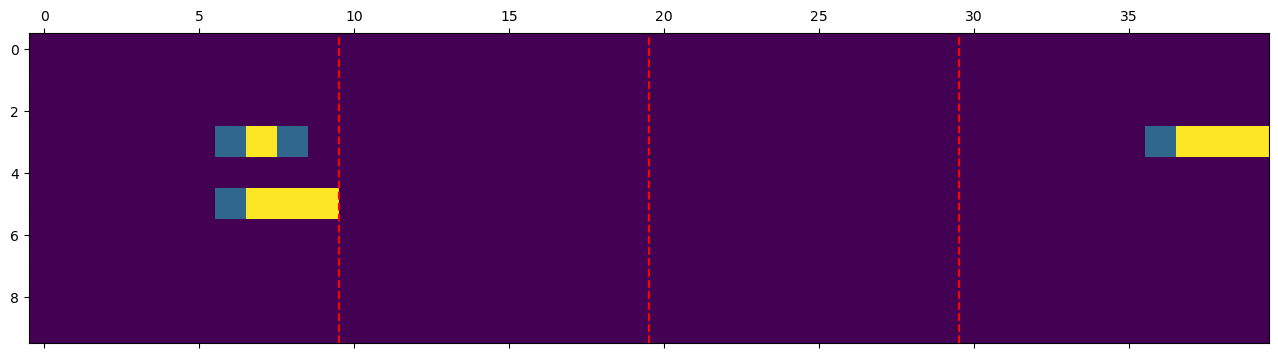

12
5639


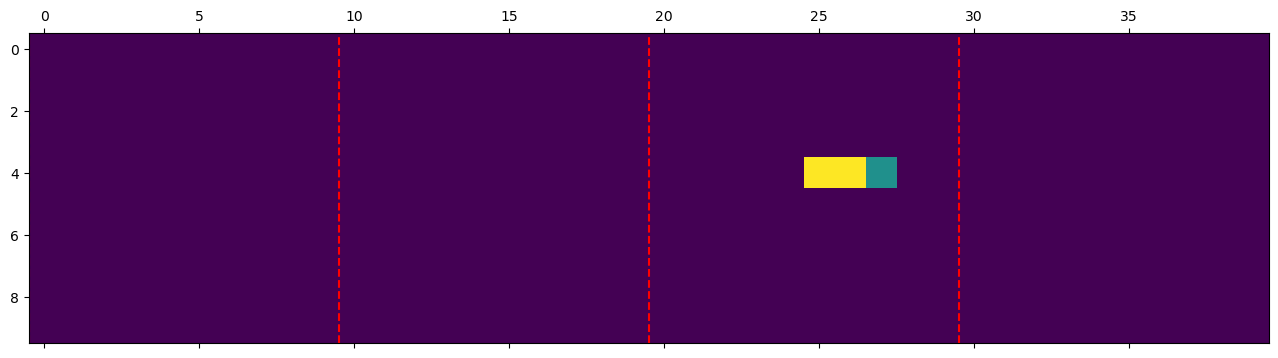

13
4787


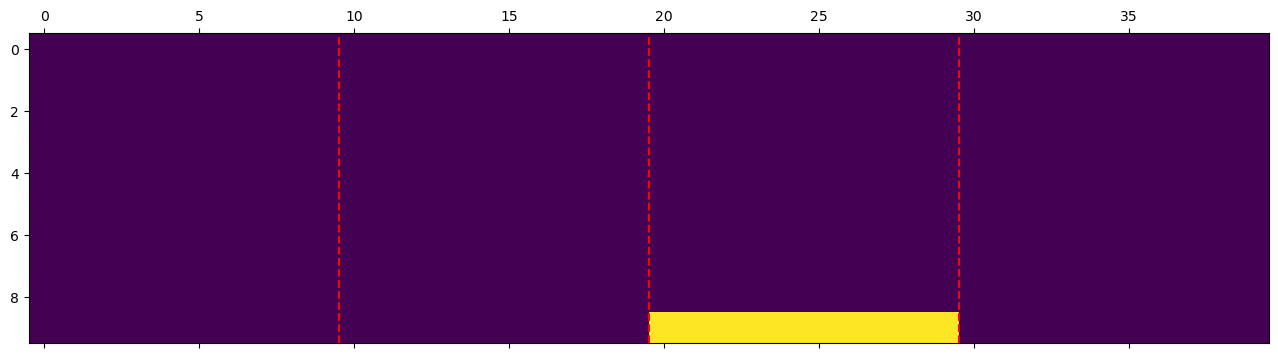

14
33665


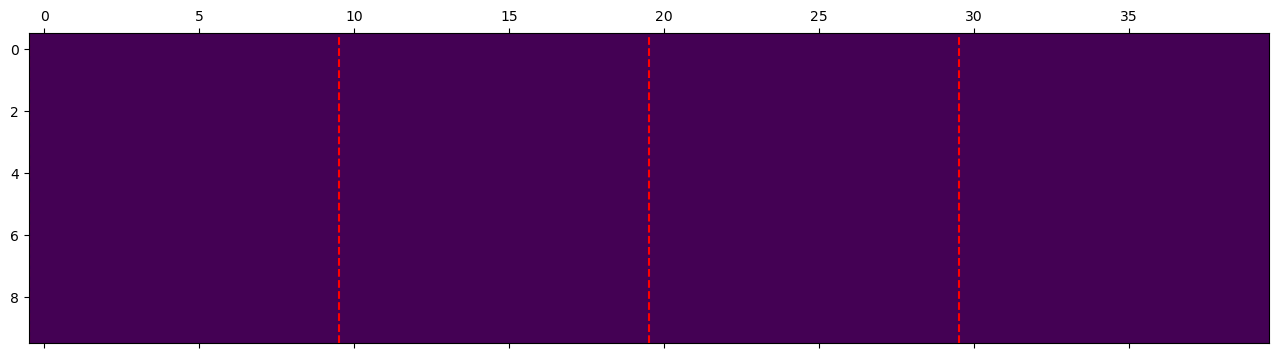

15
5306


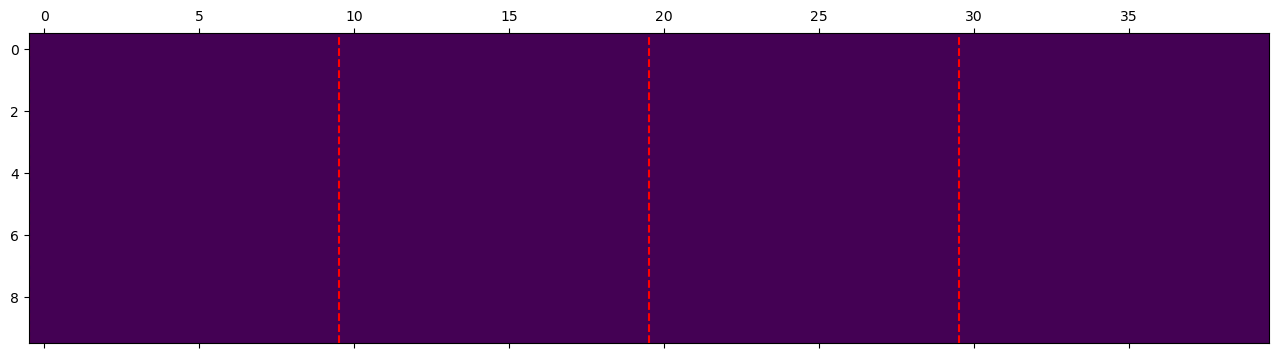

16
6200


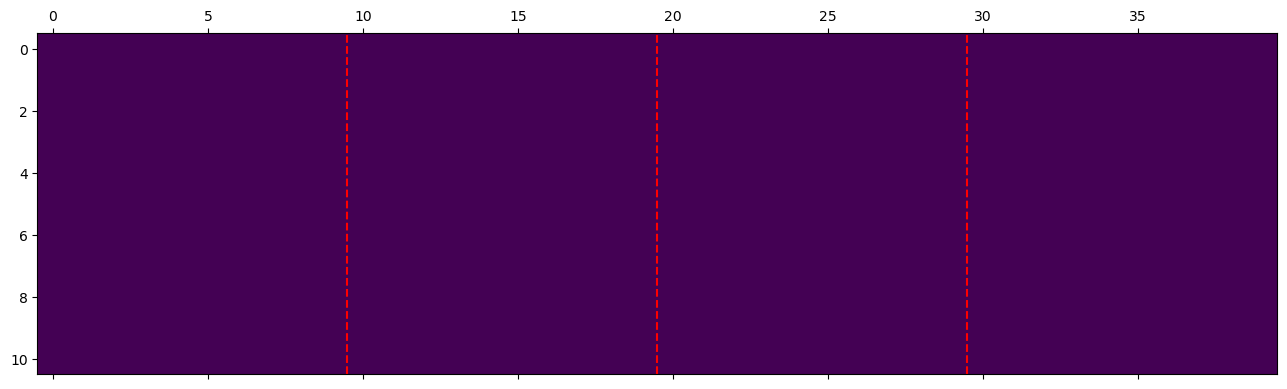

17
5206


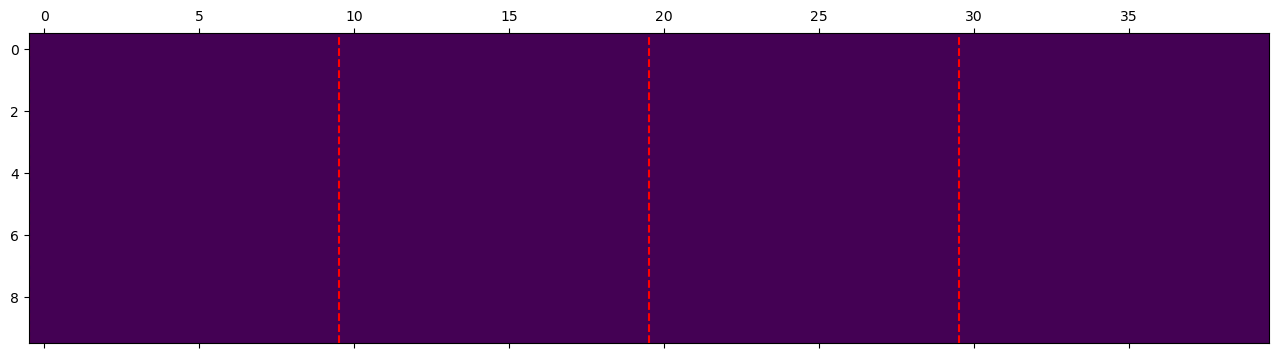

In [18]:
###Example

num_bins=10
num_states=4
num_phases=3
Neuron_norm_all=[]

print('_____')
print('Example output neuron')
print('trials x normalised time bins')
print('dashed lines represent reward times')
for ses_ind in range(len(Activity_all)):
    print(ses_ind)
    Neuron_raw=Activity_all[ses_ind]

    Trial_times=(cell_dict['timings'][ses_ind]).astype(int)
    if len(np.shape(Trial_times))!=2:
        Neuron_norm_all.append([])
        print('Not enough trials')
        continue
    num_trials=len(Trial_times)
    
    num_neurons=len(Neuron_raw)

    ##Normalisation
    Trial_times_conc=np.hstack((np.concatenate(Trial_times[:,:-1]),Trial_times[-1,-1]))//25

    Neuron_raw_neuron=Neuron_raw
    print(len(Neuron_raw_neuron))
    Neuron_raw_neuron_split=partition(list(Neuron_raw_neuron), list(Trial_times_conc))
    try:
        Neuron_raw_neuron_split_norm=np.asarray([normalise(Neuron_raw_neuron_split[ii],num_bins=num_bins)\
                                             for ii in np.arange(len(Neuron_raw_neuron_split))])
    except:
        print('Error - Not plotted')
        Neuron_norm_all.append([])
        continue
    Neuron_norm=(Neuron_raw_neuron_split_norm.reshape(len(Neuron_raw_neuron_split_norm)//4,\
                                                      len(Neuron_raw_neuron_split_norm[0])*4))
    
    ###plotting example

    plt.matshow(Neuron_norm[1:]) ##excluding first trial
    for angle in np.arange(4)*10:
        plt.axvline(angle-0.5,color='red',ls='dashed')
    plt.show()
    
    Neuron_norm_all.append(Neuron_norm)

In [19]:
import pickle
path=Input_folder+'/RpgACC_5_3_best_for_clo_model_binned'
with open(path, 'rb') as f:
    cell_dict = pickle.load(f)

In [20]:
###concatenating sessions of the same task
cell_dict.keys()
Tasks=cell_dict['reward_configs']
identical_task_indices=find_identical_indices(Tasks)
unique_tasks=Tasks[[identical_task_indices[ii][0] for ii in range(len(identical_task_indices))]]

Activity_all=cell_dict[list(cell_dict.keys())[0]]
Location_all=cell_dict['locations']


Activity_all_pertask=[]
Location_all_pertask=[]

for task_ind in np.arange(len(unique_tasks)):
    ses_indices=identical_task_indices[task_ind]
    
    Activity_task=np.hstack((np.asarray(Activity_all)[ses_indices]))
    Location_task=np.hstack((np.asarray(Location_all)[ses_indices]))
    
    Activity_all_pertask.append(Activity_task)
    Location_all_pertask.append(Location_task)
    

/var/folders/h2/_86s79551w1734r87y2wlkk40000gt/T/ipykernel_39908/847017041.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Activity_task=np.hstack((np.asarray(Activity_all)[ses_indices]))
/var/folders/h2/_86s79551w1734r87y2wlkk40000gt/T/ipykernel_39908/847017041.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Location_task=np.hstack((np.asarray(Location_all)[ses_indices]))


In [21]:
print(unique_tasks)

[[3. 9. 4. 6.]
 [9. 8. 6. 4.]
 [7. 5. 8. 1.]
 [1. 5. 2. 3.]
 [7. 3. 1. 9.]
 [2. 1. 5. 8.]]


/var/folders/h2/_86s79551w1734r87y2wlkk40000gt/T/ipykernel_39908/688750525.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['A', '', 'B', '', 'C', '', 'D', ''],fontsize=fontsize)


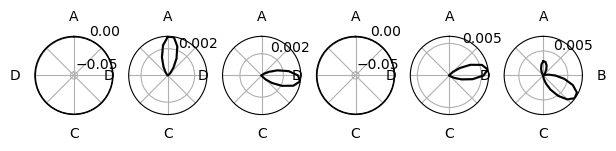

In [22]:
repeated=False
fig= plt.figure(figsize=plt.figaspect(1)*4.5)
fig.tight_layout()
sigma=2
for ses_ind in range(len(Activity_all_pertask)):
    Neuron_norm=Neuron_norm_all[ses_ind]
    if len(Neuron_norm)==0:
        continue
    mean_=np.nanmean(Neuron_norm,axis=0)
    mean_smooth=smooth_circular(mean_,sigma=sigma)  
    
    sem_=st.sem(Neuron_norm,axis=0,nan_policy='omit')
    sem_smooth=smooth_circular(sem_,sigma=sigma) 
    upperx=mean_smooth#+sem_
    lowerx=mean_smooth#+sem_
    
    ax = fig.add_subplot(1, len(Activity_all), ses_ind+1, projection='polar')
    polar_plot_stateX2(mean_smooth,upperx,lowerx,ax,repeated,color='black',labels='states',plot_type='line',Marker=False,\
                          fields_booleanx=[], structure_abstract='ABCD',fontsize=10,set_max=False,max_val=1)

In [23]:
###concatenating sessions of the same task

Tasks=cell_dict['reward_configs']
identical_task_indices=find_identical_indices(Tasks)
unique_tasks=Tasks[[identical_task_indices[ii][0] for ii in range(len(identical_task_indices))]]



Neuron_norm_all_pertask=[]

for task_ind in np.arange(len(unique_tasks)):
    ses_indices=identical_task_indices[task_ind]
    

    
    Neuron_norm_task=[]
    for ses_ind in ses_indices:
        Trial_times=(cell_dict['timings'][ses_ind]).astype(int)
        if len(np.shape(Trial_times))!=2:
            #Neuron_norm_task.append([])
            print('Not enough trials')
            continue
        num_trials=len(Trial_times)
        num_neurons=len(Neuron_raw)

        ##Normalisation
        Trial_times_conc=np.hstack((np.concatenate(Trial_times[:,:-1]),Trial_times[-1,-1]))//25

        Neuron_raw_neuron=Neuron_raw
        print(len(Neuron_raw_neuron))
        Neuron_raw_neuron_split=partition(list(Neuron_raw_neuron), list(Trial_times_conc))
        try:
            Neuron_raw_neuron_split_norm=np.asarray([normalise(Neuron_raw_neuron_split[ii],num_bins=num_bins)\
                                                 for ii in np.arange(len(Neuron_raw_neuron_split))])
        except:
            print('Error - Not plotted')
            Neuron_norm_all.append([])
            continue
        Neuron_norm=(Neuron_raw_neuron_split_norm.reshape(len(Neuron_raw_neuron_split_norm)//4,\
                                                          len(Neuron_raw_neuron_split_norm[0])*4))
        
        Neuron_norm_task.append(Neuron_norm)
        
    Neuron_norm_task=np.vstack((Neuron_norm_task))
    Neuron_norm_all_pertask.append(Neuron_norm_task)


5206
5206
5206
5206
5206
5206
5206
5206
5206
5206
5206
5206
5206
5206
5206
5206
5206
5206


/var/folders/h2/_86s79551w1734r87y2wlkk40000gt/T/ipykernel_39908/688750525.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([np.asarray(alist[i:j]) for i, j in zip(indices[:-1], indices[1:])])


/var/folders/h2/_86s79551w1734r87y2wlkk40000gt/T/ipykernel_39908/688750525.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['A', '', 'B', '', 'C', '', 'D', ''],fontsize=fontsize)


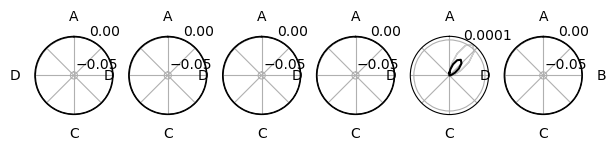

In [24]:
repeated=False
fig= plt.figure(figsize=plt.figaspect(1)*4.5)
fig.tight_layout()
sigma=2
for task_ind in range(len(Neuron_norm_all_pertask)):
    Neuron_norm=Neuron_norm_all_pertask[task_ind]
    if len(Neuron_norm)==0:
        continue
    mean_=np.nanmean(Neuron_norm,axis=0)
    mean_smooth=smooth_circular(mean_,sigma=sigma)  
    
    sem_=st.sem(Neuron_norm,axis=0,nan_policy='omit')
    sem_smooth=smooth_circular(sem_,sigma=sigma) 
    upperx=mean_smooth+sem_smooth
    lowerx=mean_smooth+sem_smooth
    
    ax = fig.add_subplot(1, len(Activity_all), task_ind+1, projection='polar')
    polar_plot_stateX2(mean_smooth,upperx,lowerx,ax,repeated,color='black',labels='states',plot_type='line',Marker=False,\
                          fields_booleanx=[], structure_abstract='ABCD',fontsize=10,set_max=False,max_val=1)